# Evaluating speech polarization over time

In [3]:
PATH = "/home/piotr/projects/twitter"
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import gc
import json
import pickle
from datetime import datetime, timedelta
import random
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import itertools
from functools import partial
import os
import ast
import pdb
import sys
sys.path.append(os.path.join(PATH, 'src'))
from twitter_models.polarization import ModelPolarization
from twitter_tools.utils import read_files, clean_tweets, filter_data
from twitter_tools.evaluation import polarization as evaluation
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import logging
import statsmodels.api as sm

In [6]:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        word = line.strip('\n')
        if word != 'nie':
            stopwords.append(word)
stopwords.append('mieć')
PATH_DROP = os.path.join(PATH, 'results/cleaning/DROP_IDS.json')
START = '2020_02_23'
END = '2020_07_15'
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))

In [7]:
gov = pickle.load(open(os.path.join(PATH, 'data/sample/gov_sample.p'),"rb"))
opp = pickle.load(open(os.path.join(PATH, 'data/sample/opp_sample.p'),"rb"))
parties = {k:"gov" for k in gov}
parties.update({k:"opp" for k in opp})
PATH_DATA = os.path.join(PATH, "data/clean")


#Get random assignment
random_keys = list(parties.keys()); random.shuffle(random_keys) #randomize keys
random_values = list(parties.values()); random.shuffle(random_values) #randomize values
randomized = dict(zip(random_keys, random_values)) #zip into dict

The call below writes a new file that contains data from the day-level files filtered using the data filtering function defined above:

In [8]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))

#filter function:
def filter_fun(df:pd.DataFrame, drop_users:list, drop_tweets:list):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    df.drop_duplicates(inplace = True, subset = ['lemmatized'])
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets)

# Leave out estimator of partisanship (Gentzkow et al. 2020)

*The leave-out estimator of partisanship is obtained using the following process. Each user's speech-generating process is assumed to follow a multinomial distribution over the possible phrase set, where each phrase is picked with a certain choice probability. The*


\begin{equation}
\hat{\pi}_{t}^{LO} = \frac{1}{2} \frac{1}{|R_{t}|} \sum_{i \in R_{t}} \hat{q}_{i,t}  \cdot \hat{p}_{-i,t} +  \frac{1}{2} \frac{1}{|D_{t}|} \sum_{i \in D_{t}} \hat{q}_{i,t}  \cdot (1 - \hat{p}_{-i,t})\\
\end{equation}


$\hat{p}_{-i,t} = \hat{q}_{-i,t}^{R} / (\hat{q}_{-i,t}^{R} + \hat{q}_{-,it}^{D})$ is the probability of an observer with a neutral prior assigning a speaker to government based only on a given phrase



$\hat{q}_{i,t} = c_{i,t} / m_{i,t}$ are the phrase frequencies for speaker $i$ at time $t$ 




*The estimation of confidence interval for the leave-out estimator is obtained via sub-sampling, using the procedure described by Gentzkow et al. (2019), based on Politis et al. (1990) procedure. Specifically:*

(THE CI FORMULA GOES HERE)

## 1. Overall partisanship
- using all data
- excluding retweets

#### a. Day-level estimates: 

In [14]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day]["true"] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day]["random"] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
    results = dict(results) #convert defaultdict to dict
    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')
    results.to_csv(PATH_RESULTS)

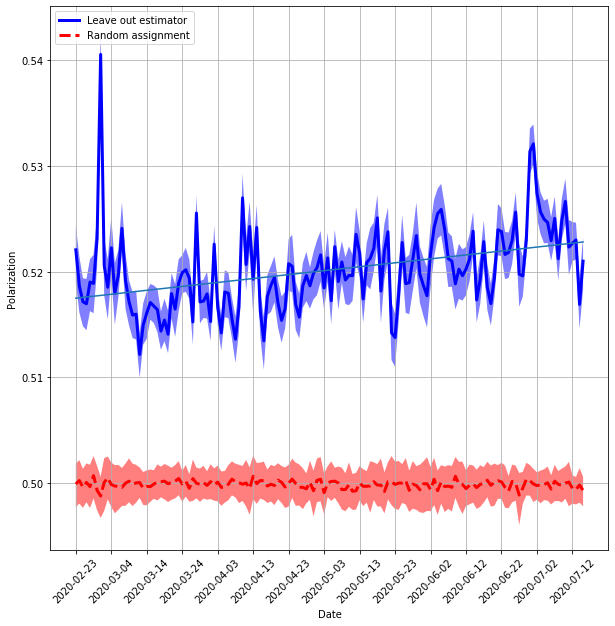

In [68]:
evaluation.plot_aggregated(results, trend_line = True)

#### b. Week-level estimates: 

In [18]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_weekly.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS)
else:
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, batch_size = 7, 
                                dtype = dtypes, filter_fun = ff)):
        #get period:
        dates = pd.to_datetime(data.day)
        date_min = dates.min().strftime('%d/%m')
        date_max = dates.max().strftime('%d/%m')
        week = date_min + '-' + date_max
        
        #fit model
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[week]["true"] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)

        #fit randomized model:
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 50, ngram_range = (1,2))
        results[week]["random"] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
    results = dict(results) #convert defaultdict to dict
    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')
    results.columns = ['date','type','lower_ci','upper_ci','estimate']
    results.to_csv(PATH_RESULTS)

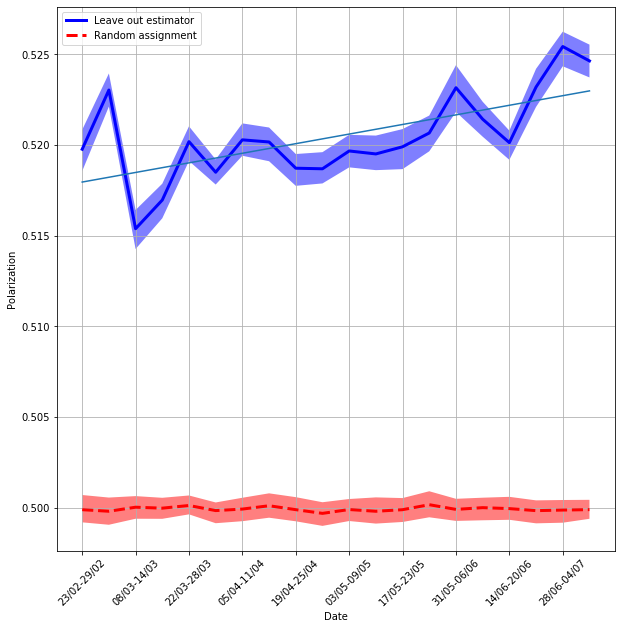

In [19]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 2)
plt.show()

#### c. Day-level rolling estimates

In [33]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_rolling_window.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS)
else:
    results = defaultdict(dict) #store results
    fmt = '%Y_%m_%d' #date formatting for files
    START2 = (datetime.strptime(START, fmt) + timedelta(days = 7)).strftime(fmt)
    reader = partial(read_files, path = PATH_DATA, day_to = END, dtype = dtypes, filter_fun = ff)
    reader_weekly = reader(day_from = START, batch_size = 7)
    reader_daily = reader(day_from = START2, batch_size = 1)
    data = next(reader_weekly) #get first week
    data['day'] = pd.to_datetime(data['day']) #convert to datetime
    for df in tqdm(reader_daily):
        df['day'] = pd.to_datetime(df['day'])
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = logging.INFO)
        model.prefit(data["lemmatized"].astype(str).to_numpy())
        #fit only for the middle date from the window
        window = data['day'].unique() #current window
        mid_date = sorted(window)[3] #get middle entry
        data_mid = data[data['day'] == mid_date]
        mid_date_str = np.datetime_as_string(mid_date, unit = 'D') #convert to string for key
        results[mid_date_str]['true'] = model.estimate(data_mid['source'], 
                                                         data_mid['user-id_str'], 
                                                         data_mid['lemmatized'], 
                                                         level = 'aggregate',
                                                         conf_int = 100)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = logging.INFO)
        model.prefit(data["lemmatized"].astype(str).to_numpy())
        random_parties = data_mid["user-id_str"].astype(str).map(randomized)
        results[mid_date_str]['random'] = model.estimate(random_parties, 
                                                     data_mid['user-id_str'], 
                                                     data_mid['lemmatized'], 
                                                     level = 'aggregate',
                                                     conf_int = 100)

        data = data[data.day != data.day.min()] #filter out oldest day
        data = data.append(df)

    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')
    results.index.names = ['date','type']
    results.to_csv(PATH_RESULTS)

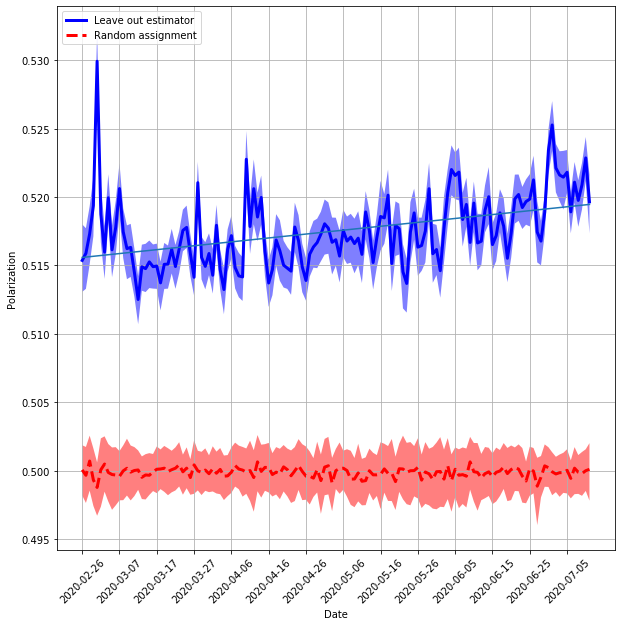

In [34]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 10)
plt.show()

## 2. Within-topics partisanship, based on the LDA-Mallet topic model

#### Day-level estimates of topic partisanship best on the 21-topic LDA-Mallet topic model:

In [6]:
topic_map = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topics.json'), 'r'))
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_mallet_new.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col = ['topic','date'])
else:
    results = defaultdict(lambda: defaultdict(dict))
    for df in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, batch_size = 1, 
                                dtype = dtypes, filter_fun = ff)):
        
        df['topic'] = df['id_str'].astype(str).map(topic_map).astype(int)
        #fit vectorizer on all vocabulary:
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = 20)
        _ = model._vectorize_text(df["lemmatized"].astype(str).to_numpy())
        del _
        gc.collect()
        
        #iterate over each topic:
        for k in sorted(np.unique(list(topic_map.values()))):
            data = df.loc[df['topic'] == k]
            parties = data["source"] #get parties 
            users = data["user-id_str"] #get users 
            tweets = data["lemmatized"].astype(str) #get tweets
            day = data['day'].unique()[0]
            try:
                results[k][day] = model.estimate(parties, users, tweets, level = "aggregate", conf_int = None)
            except:
                continue
            results[k] = dict(results[k])
    results = dict(results) #convert defaultdict to dict
    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')

    results.index.names = ['topic','date']
    results.reset_index(inplace = True)
    results[['gov','opp']] = pd.json_normalize(results['n'])
    del results['n']
    results.set_index(['topic','date'], inplace = True)
    results.to_csv(PATH_RESULTS)

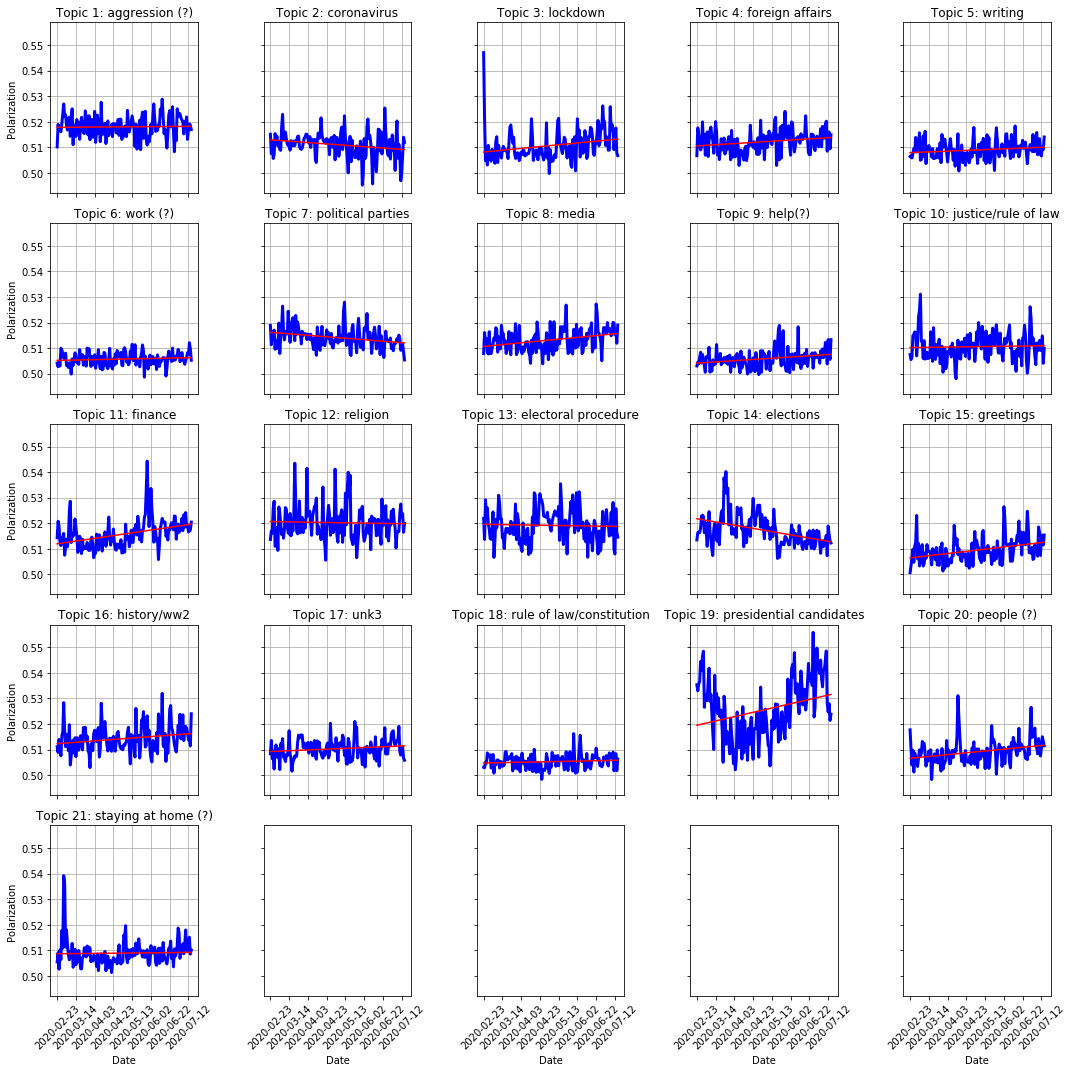

In [53]:
results = results.reset_index()
topic_dict = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topic_dict.json'), 'r'))
evaluation.plot_aggregated_bytopic(results.date, results['point'], results.topic, topic_dict = topic_dict, figsize = (15, 15), trend_line = True)

#### Daily rolling estimates by topic

In [ ]:
topic_map = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topics.json'), 'r'))
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_topics_rolling_window.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS)
else:
    results = defaultdict(lambda: defaultdict(dict)) #store results
    fmt = '%Y_%m_%d' #date formatting for files
    START2 = (datetime.strptime(START, fmt) + timedelta(days = 7)).strftime(fmt)
    reader = partial(read_files, path = PATH_DATA, day_to = END, dtype = dtypes, filter_fun = ff)
    reader_weekly = reader(day_from = START, batch_size = 7)
    reader_daily = reader(day_from = START2, batch_size = 1)
    data = next(reader_weekly) #get first week
    data['day'] = pd.to_datetime(data['day']) #convert to datetime
    data['topic'] = data['id_str'].astype(str).map(topic_map).astype(int)
    for df in tqdm(reader_daily):
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = logging.INFO)
        model.prefit(data["lemmatized"].astype(str).to_numpy())
        #fit only for the middle date from the window
        window = data['day'].unique() #current window
        mid_date = sorted(window)[3] #get middle entry
        data_mid = data[data['day'] == mid_date]
        mid_date_str = np.datetime_as_string(mid_date, unit = 'D') #convert to string for key
        for k in np.unique(list(topic_map.values())):
            data_mid_t = data_mid.loc[data_mid['topic'] == k]
            parties = data_mid_t["source"] #get parties 
            users = data_mid_t["user-id_str"] #get users 
            tweets = data_mid_t["lemmatized"].astype(str) #get tweets
            results[mid_date_str][k] = model.estimate(parties, users, tweets, level = "aggregate", conf_int = None)
        results[mid_date_str] = dict(results[mid_date_str]) #convert it to dict
        
        #remove one day:
        data = data[data.day != data.day.min()] 
        
        #add one day
        df['topic'] = df['id_str'].astype(str).map(topic_map).astype(int)
        df['day'] = pd.to_datetime(df['day'])
        data = data.append(df)
    results = dict(results)

    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                              for i in results.keys() 
                              for j in results[i].keys()}, orient = 'index')

    results.index.names = ['topic','date']
    results.reset_index(inplace = True)
    results[['gov','opp']] = pd.json_normalize(results['n'])
    del results['n']
    results.set_index(['topic','date'], inplace = True)
    results.to_csv(PATH_RESULTS)

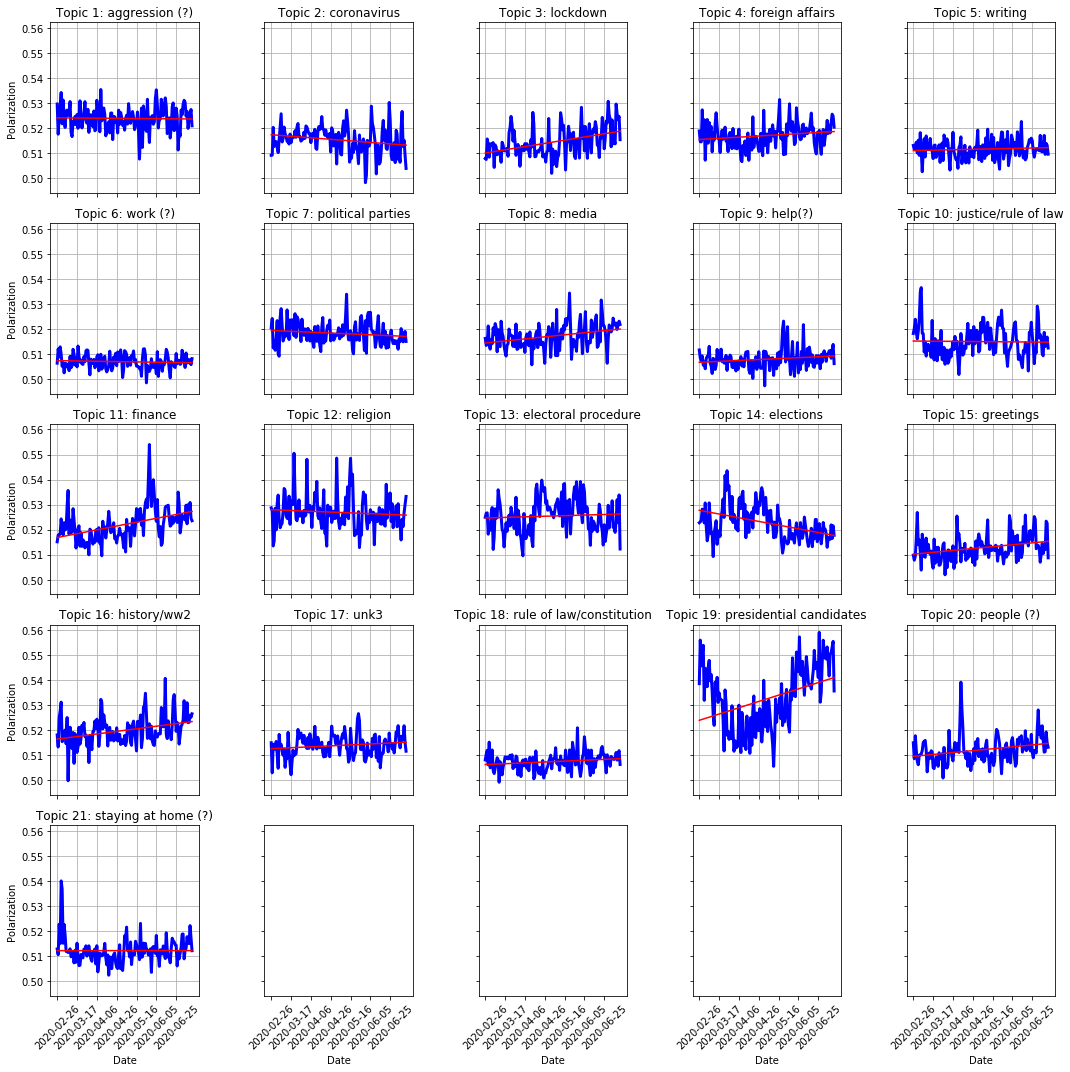

In [30]:
results = results.reset_index()
topic_dict = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topic_dict.json'), 'r'))
evaluation.plot_aggregated_bytopic(results.date, results['point'], results.topic, topic_dict = topic_dict, figsize = (15, 15), trend_line = True)

### Polarization autocorrelation within each topic:
To examine the presence of the trend, I have also plotted the autocorrelation of each topic-polarization time series for 20 lags.

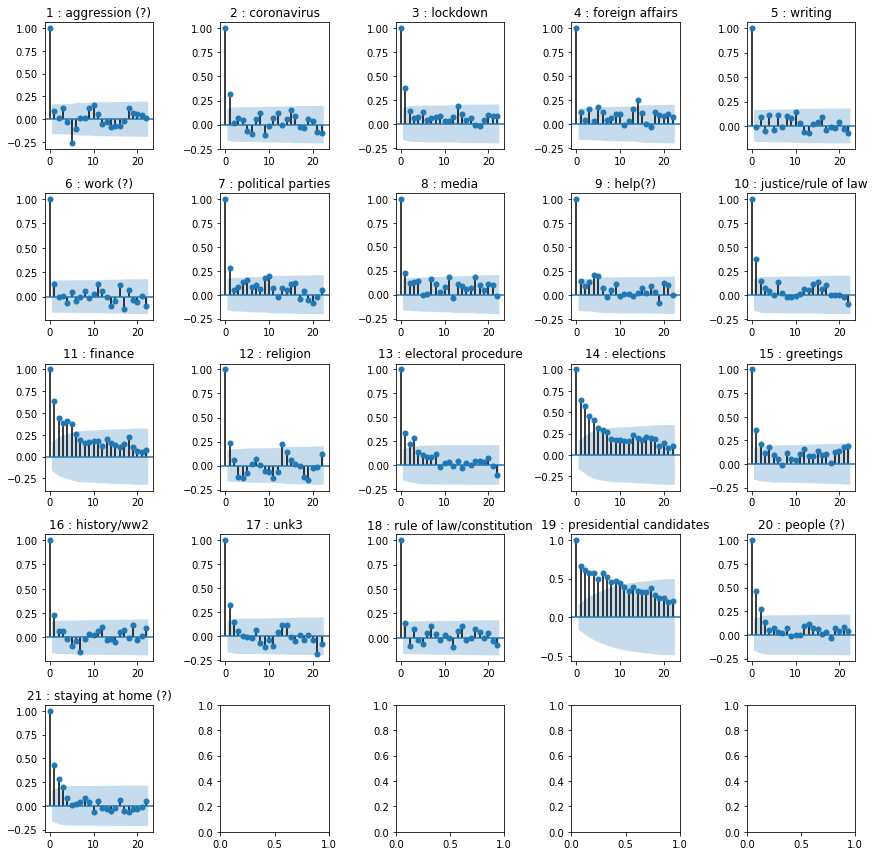

In [21]:
topic_dict = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topic_dict.json'), 'r'))
ntopics = results.reset_index()['topic'].unique().size
side = int(np.ceil(np.sqrt(ntopics)))
fig, ax = plt.subplots(side, side, figsize = (12, 12))
ax = ax.ravel()
for topic, df in results.reset_index().groupby('topic'):
    plot_acf(df['point'], ax = ax[topic-1])
    ax[topic-1].set_title(f'{topic} : {topic_dict[str(topic)]}')
plt.tight_layout()
plt.show()

### Linear fits:
To further examine the presence of trend in within-topic polarization, I fitted an OLS regression in each of the topic, and examined the slope and the intercept. 

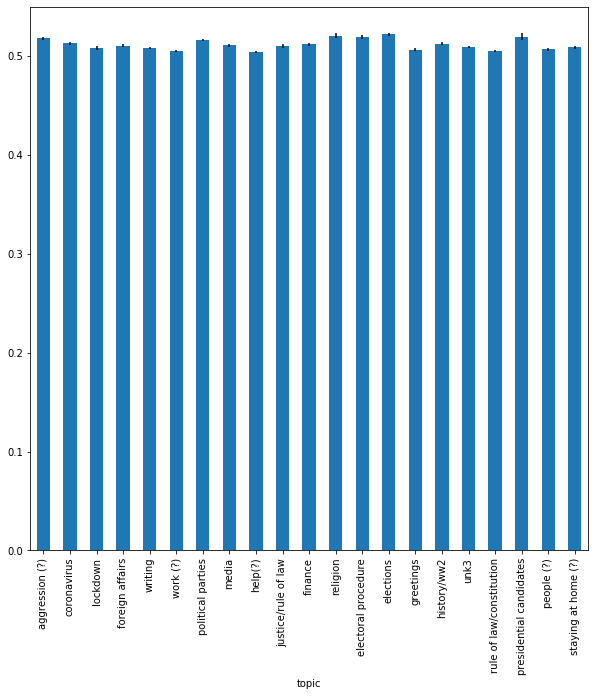

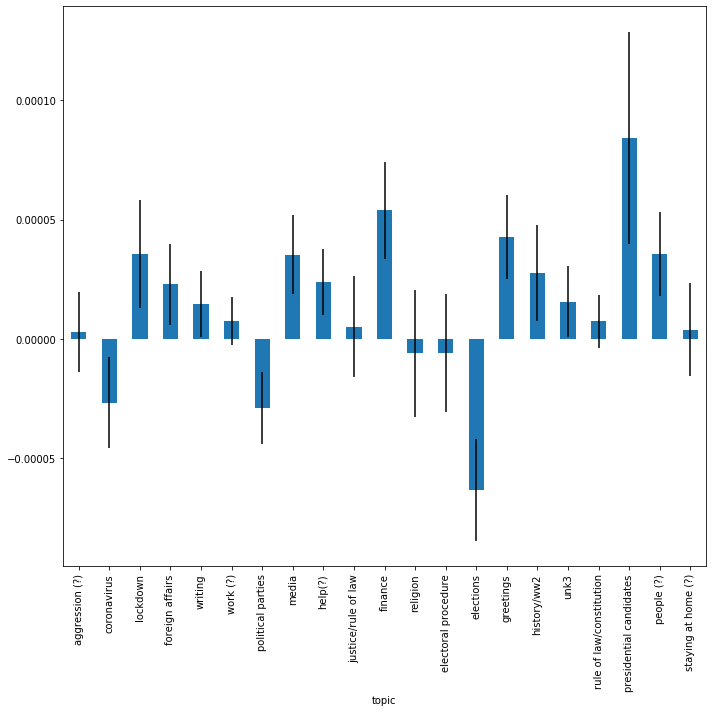

In [54]:
fits = pd.DataFrame(columns = ['lower','upper', 'point','topic'])
date_num = np.arange(len(np.unique(results.reset_index().date)))
X = sm.add_constant(date_num)
for topic, df in results.groupby('topic'):
    model = sm.OLS(df['point'], X)
    fit = model.fit()
    res = fit.conf_int()
    res.columns = ['lower','upper']
    res['point'] = fit.params
    res['topic'] = topic
    fits = fits.append(res)
fits.set_index('topic', inplace = True, append = True)
fits.index.names = ['coef','topic']
fits = fits.reset_index()
fits['topic'] = fits.topic.astype(str).map(topic_dict)
fits['err'] = fits['upper'] - fits['point']
axes = fits.reset_index().groupby(['coef']).plot.bar('topic','point',figsize = (10, 10), yerr = 'err')
for ax in axes:
    ax.get_legend().remove()
    #ax.set_xticklabels(fits['topic'].unique(), rotation = 45)
plt.tight_layout()
plt.show()

The level of partisanship seems to have increased in the topics of presidential candidates, finance, media and decreased in political parties, coronavirus, and elections. 

### Phrase partisanship
To evaluate the partisanship of particular phrases, I obtained the posterior probability pf a phrase being assigned to the government by an observer with neutral prior based on the Gentzkow model. I then looked at phrases which occured on at least 115 days (i.e. less than 40 days missingness), and examined phrases with highest government partisanship (i.e. posterior close to 1), opposition partisanship (i.e. posterior close to 0) and highest variation in partisanship over time.

In [4]:
PATH_RES = os.path.join(PATH, 'results/polarization/phrase_partisanship.csv')
if os.path.isfile(PATH_RES):
    phrases = pd.read_csv(PATH_RES, index_col = 'date')
else:
    phrases = dict()
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        phrases[day] = model.get_posteriors(parties, users, tweets)
    phrases = pd.DataFrame.from_dict(phrases).reset_index().melt('index')
    phrases.columns = ['phrase','date','posterior']
    phrases = phrases.set_index(['date'])
    phrases.to_csv(PATH_RES)

In [9]:
phrases = phrases[np.logical_not(phrases.phrase.isin(stopwords))]
summary = phrases.groupby('phrase').agg({'posterior':[np.mean, np.std, lambda x: x.isna().sum()]})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['posterior_mean','posterior_sd','posterior_miss']

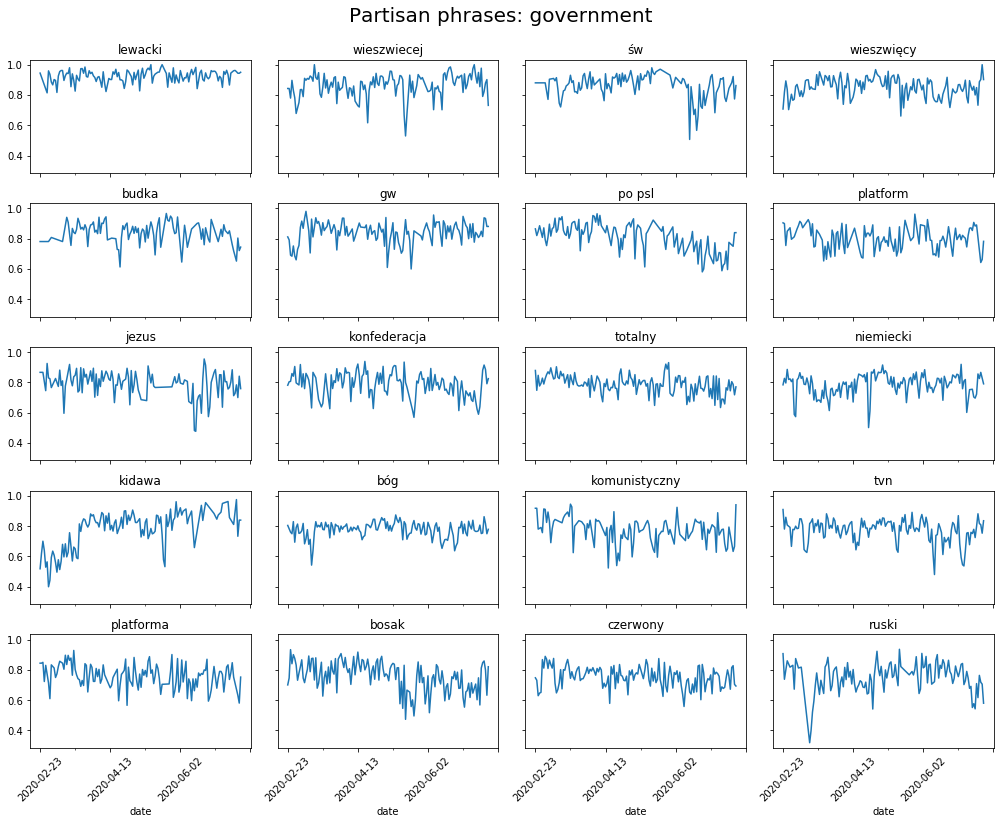

In [13]:
phrases_gov = summary[summary.posterior_miss < 40].sort_values(['posterior_mean'], ascending = False).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Partisan phrases: government', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_gov.phrase):
    phrases[phrases.phrase == phr].posterior.interpolate(method = 'linear',limit_direction = 'both').plot(rot = 45, ax = ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

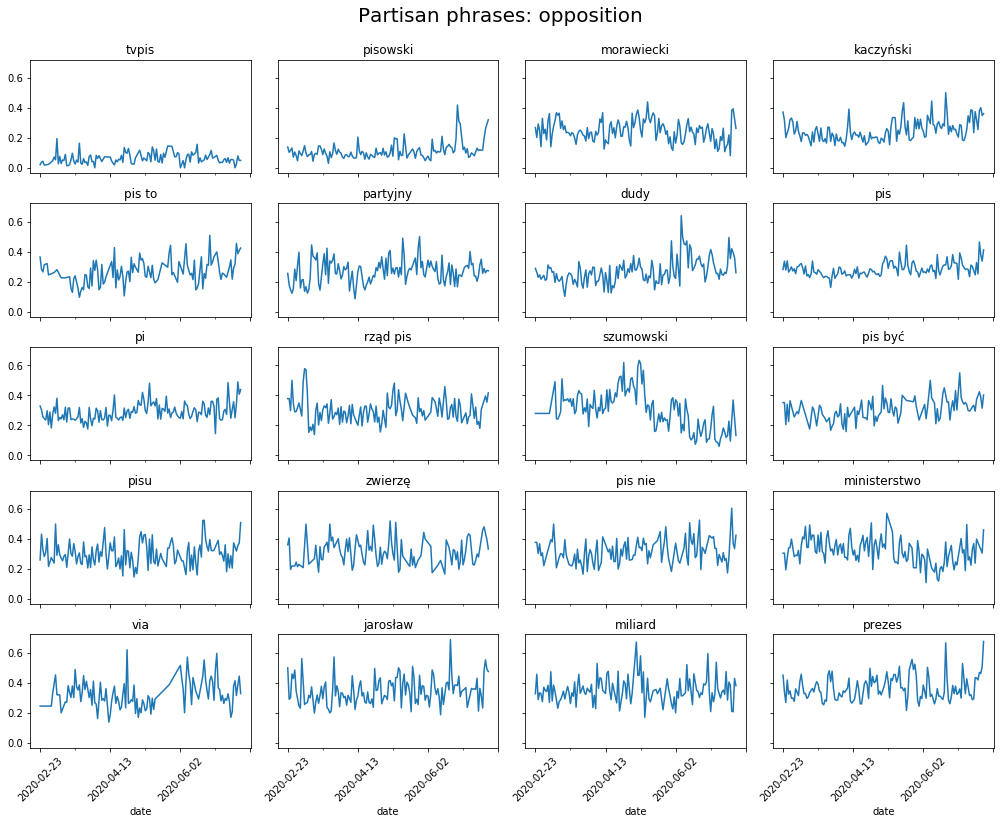

In [14]:
phrases_opp = summary[summary.posterior_miss < 40].sort_values(['posterior_mean'], ascending = True).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Partisan phrases: opposition', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_opp.phrase):
    phrases[phrases.phrase == phr].posterior.interpolate(method = 'linear',limit_direction = 'both').plot(rot = 45, ax = ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

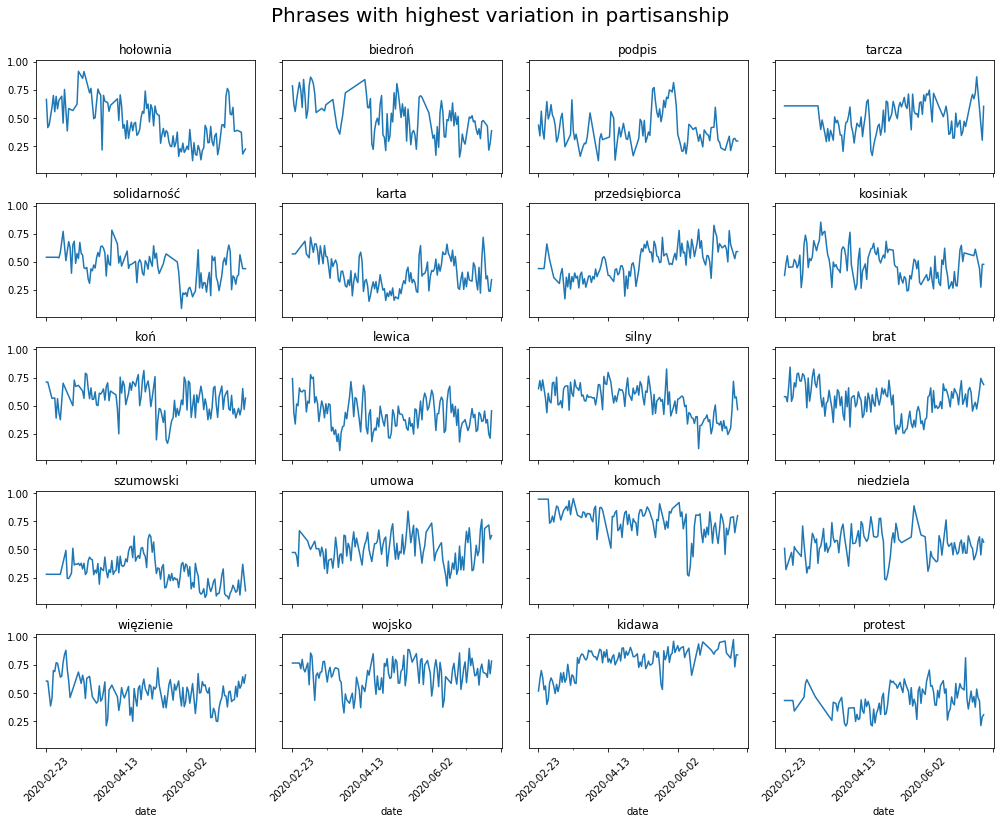

In [15]:
phrases_var = summary[summary.posterior_miss < 40].sort_values(['posterior_sd'], ascending = False).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Phrases with highest variation in partisanship', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_var.phrase):
    phrases[phrases.phrase == phr].posterior.interpolate(method = 'linear',limit_direction = 'both').plot(rot = 45, ax = ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()